In [1]:
import numpy as np
import matplotlib.pylab as plt

In [27]:
from point_configuration import PointConfiguration
from basics import create_noisy_edm

## Setup
n = 10
d = 3
e = np.ones(n)
p = PointConfiguration(n, d)
p.set_points(mode='normal')
noise = 0.01
edm_measured = create_noisy_edm(p.edm, noise)
print('init edm error:', np.linalg.norm(edm_measured - p.edm))

init edm error: 0.128855739336


In [28]:
from semidefinite import reconstruct_sdp
W = np.ones([n,n])
lamda = 1000

Xhat, EDMbest = reconstruct_sdp(edm_measured, W, lamda, p.points)

total cost: 24.46499800552175
trace of H: 24.7667220555
other cost: 27.7905595253


init edm error: 0.128855739336
final edm error: 0.105095376681
rmse: 0.00452352092845


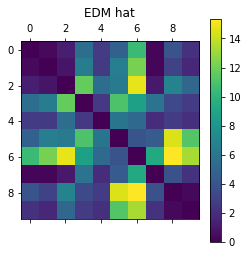

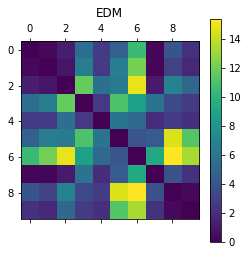

In [29]:
from plots_cti import plot_point_sets, plot_matrix
print('init edm error:', np.linalg.norm(edm_measured - p.edm))
print('final edm error:', np.linalg.norm(EDMbest - p.edm))
print('rmse:',np.linalg.norm(p.points-Xhat)/np.sqrt(len(Xhat)))
plot_matrix(EDMbest, 'EDM hat')
plot_matrix(p.edm, 'EDM')
#plot_point_sets([p.points,Xhat],names=['X','Xhat'],display_lines=True)